# SUPG Formulation for ADR Equations

$$B_{SUPG}(w^{h}, u^{h}) = B_{GAL}(w^{h}, u^{h}) + \sum_{e}{(T^{e}a\cdot\nabla{w^{h}}, Lu^{h})}_{\Omega_{e}}$$
$$L_{SUPG}(w^{h}) = L_{GAL}(w^{h}) + \sum_{e}{(T^{e}a\cdot\nabla{w^{h}}, f)}_{\Omega_{e}}$$
$$B_{GAL}(w^{h}, u^{h}) = (w^{h}, au^{h}_{,x} - ku^{h}_{,xx})$$
$$L_{GAL}(w^{h}) = (w^{h}, 12x^{2})$$
$$\therefore$$
$$B_{SUPG}(w^{h}, u^{h}) = (w^{h}, au^{h}_{,x} - ku^{h}_{,xx}) + \sum_{e}{(T^{e}a\cdot{w^{h}_{,x}}, au^{h}_{,x} - ku^{h}_{,xx})}_{\Omega_{e}}$$
IBP: 
$$B_{SUPG}(w^{h}, u^{h}) = (w^{h}_{,x}, ku^{h}_{,x} - au^{h}) + \sum_{e}{(T^{e}a\cdot{w^{h}_{,x}}, au^{h}_{,x} - ku^{h}_{,xx})}_{\Omega_{e}}$$
$$(w^{h}_{,x}, ku^{h}_{,x} - au^{h}) + \sum_{e}{(T^{e}a\cdot{w^{h}_{,x}}, au^{h}_{,x} - ku^{h}_{,xx})}_{\Omega_{e}} = (w^{h}, 12x^{2}) + \sum_{e}{(T^{e}a\cdot\nabla{w^{h}}, f)}_{\Omega_{e}}$$


In [1]:
from nutils import function, mesh, solver
from nutils.expression_v2 import Namespace
import io
import sys
import numpy
from matplotlib import pyplot as plt

In [17]:
def Ta(h, k, a):
    Peclet = a*h/(2*k)
    S = (1/numpy.tanh(Peclet)) - 1/(Peclet)
    print("a,: {}, k: {}, S: {}, h: {}".format(a,k,S,h))
    return (h*S)/(2*a)

def advection_diffusion_reaction_SUPG(n, a=1, k=1, f='12 x_0^2',basis='lagrange'):
    #basis = 'lagrange' 'spline' 'std' 'discount'
    #Suppress output of Nutils
    text_trap = io.StringIO()
    sys.stdout = sys.stderr = text_trap
    ns = Namespace()
    topo, geom = mesh.rectilinear([numpy.linspace(0, 1, n+1)])
    ns.x = geom
    ns.a = a
    ns.k = k
    ns.define_for('x', gradient='d', normal='n', jacobians=('dV', 'dS'))
    ns.basis = topo.basis(basis, degree=1)
    ns.u = function.dotarg('lhs', ns.basis)
    ns.laplace = function.laplace(ns.u, geom)
    ns.f = f
    Taf = Ta((1/n), k, a)
    ns.Ta = Taf
    sqr = topo.boundary['right'].integral('(u - 1)^2 dS' @ ns, degree=1)
    cons = solver.optimize('lhs', sqr, droptol=1e-15)
    res = topo.integral('(k d_i(u) d_i(basis_n) - a u d_0(basis_n) + Ta a^2 d_i(basis_n) d_i(u) - Ta a k d_0(basis_n) laplace) dV' @ ns, degree=2)
    #res = topo.integral('(k d_i(u) d_i(basis_n) - a u d_0(basis_n) + Ta a^2 d_i(basis_n) d_i(u)) dV' @ ns, degree=1)
    #res += topo.integral('(Ta a d_i(basis_n) - k d_i(basis_n) d_0(u)) dS' @ ns, degree=2)
    res -= topo.integral('(f basis_n) dV' @ ns, degree=1)
    res -= topo.integral('(Ta a  f d_0(basis_n)) dV' @ ns, degree=1)
    res #-= topo.boundary['right'].integral('a d_0(basis_n) u dS' @ ns, degree=2)
    res #+= topo.boundary['right'].integral('k d_0(basis_n) d_0(u) dS' @ ns, degree=2)
    lhs = solver.solve_linear('lhs', residual=res, constrain=cons)
    return ns, lhs

def advection_diffusion_reaction_Galerkin(n, a=1, k=1, f='12 x_0^2',basis='lagrange'):
    #basis = 'lagrange' 'spline' 'std' 'discount'
    #Suppress output of Nutils
    text_trap = io.StringIO()
    sys.stdout = sys.stderr = text_trap
    ns = Namespace()
    topo, geom = mesh.rectilinear([numpy.linspace(0, 1, n+1)])
    ns.x = geom
    ns.a = a
    ns.k = k
    ns.define_for('x', gradient='d', normal='n', jacobians=('dV', 'dS'))
    ns.basis = topo.basis(basis, degree=1)
    ns.u = function.dotarg('lhs', ns.basis)
    ns.laplace = function.laplace(ns.u, geom)
    ns.f = f
    sqr = topo.boundary['right'].integral('(u - 1)^2 dS' @ ns, degree=1)
    cons = solver.optimize('lhs', sqr, droptol=1e-15)
    res = topo.integral('(k d_i(u) d_i(basis_n) - a u d_0(basis_n)) dV' @ ns, degree=2)
    res -= topo.integral('(f basis_n) dV' @ ns, degree=1)
    lhs = solver.solve_linear('lhs', residual=res, constrain=cons)
    return ns, lhs

nanjoin = lambda array, tri: numpy.insert(array.take(tri.flat, 0).astype(float), slice(tri.shape[1], tri.size, tri.shape[1]), numpy.nan, axis=0)

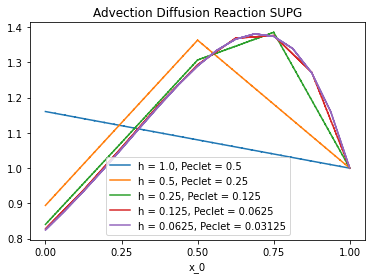

In [18]:
def plot_SUPG(n, a=1, k=1, **kwargs):
    topo, geom = mesh.rectilinear([numpy.linspace(0, 1, n+1)])
    bezier = topo.sample('bezier', 32)
    ns, ns_lhs = advection_diffusion_reaction_SUPG(n, a, k, **kwargs)
    sampled_x = nanjoin(bezier.eval('x_0' @ ns), bezier.tri)
    plt.plot(sampled_x, nanjoin(bezier.eval(ns.u, lhs=ns_lhs), bezier.tri), label="h = {}, Peclet = {}".format((1/n), a/(2*k*n)))

def plot_Galerkin(n, a=1, k=1, **kwargs):
    topo, geom = mesh.rectilinear([numpy.linspace(0, 1, n+1)])
    bezier = topo.sample('bezier', 32)
    ns, ns_lhs = advection_diffusion_reaction_Galerkin(n, a, k, **kwargs)
    sampled_x = nanjoin(bezier.eval('x_0' @ ns), bezier.tri)
    plt.plot(sampled_x, nanjoin(bezier.eval(ns.u, lhs=ns_lhs), bezier.tri), label="h = {}, Peclet = {}".format((1/n), a/(2*k*n)))

plot_SUPG(1, a=1)
plot_SUPG(2, a=1)
plot_SUPG(4, a=1)
plot_SUPG(8, a=1)
plot_SUPG(16, a=1)


plt.xlabel('x_0')
plt.xticks(numpy.linspace(0, 1, 5))
plt.title("Advection Diffusion Reaction SUPG".format(1))
plt.legend()

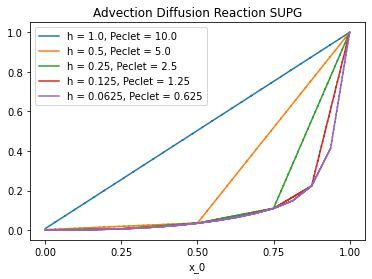

In [19]:
plot_SUPG(1, a=20)
plot_SUPG(2, a=20)
plot_SUPG(4, a=20)
plot_SUPG(8, a=20)
plot_SUPG(16, a=20)


plt.xlabel('x_0')
plt.xticks(numpy.linspace(0, 1, 5))
#plt.yticks(numpy.linspace(0, 1, 5))
plt.title("Advection Diffusion Reaction SUPG")
plt.legend()

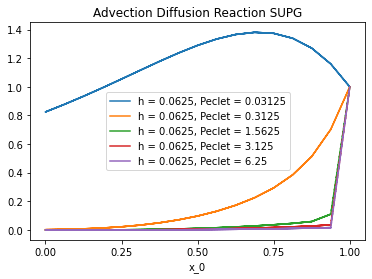

In [20]:
plot_SUPG(16, a=1)
plot_SUPG(16, a=10)
plot_SUPG(16, a=50)
plot_SUPG(16, a=100)
plot_SUPG(16, a=200)



plt.xlabel('x_0')
plt.xticks(numpy.linspace(0, 1, 5))
#plt.yticks(numpy.linspace(0, 1, 5))
plt.title("Advection Diffusion Reaction SUPG")
plt.legend()

# The galerkin method breaks for large advection, note presence of 'squiggles'

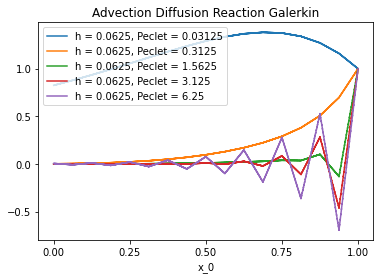

In [21]:
plot_Galerkin(16, a=1)
plot_Galerkin(16, a=10)
plot_Galerkin(16, a=50)
plot_Galerkin(16, a=100)
plot_Galerkin(16, a=200)



plt.xlabel('x_0')
plt.xticks(numpy.linspace(0, 1, 5))
#plt.yticks(numpy.linspace(0, 1, 5))
plt.title("Advection Diffusion Reaction Galerkin")
plt.legend()

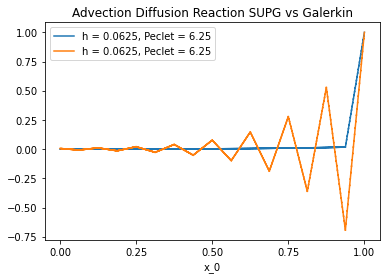

In [22]:
plot_SUPG(16, a=200)
plot_Galerkin(16, a=200)



plt.xlabel('x_0')
plt.xticks(numpy.linspace(0, 1, 5))
#plt.yticks(numpy.linspace(0, 1, 5))
plt.title("Advection Diffusion Reaction SUPG vs Galerkin")
plt.legend()

# Problem 3

 Calculate Flux using $au^{h}(x) - ku^{h}_{,x}(x)$ at boundary $x = 1$ with $a = 20$

In [23]:
def Nmax(x, mesh, delta):    
    if x < 0:
        return 0
    elif x < mesh[len(mesh)-2]:
        return 0
    else:
        u = (x - mesh[len(mesh)-2])/delta
        return u

def Nmaxprime(x, mesh, delta):   
    if x < 0:
        return 0
    elif x < mesh[len(mesh)-2]:
        return 0
    else:
        u = (1)/delta
        return u
    
200*Nmaxprime(1, [0, .25, .5, .75, 1.0], .25) - 1*Nmaxprime(1, [0, .25, .5, .75, 1.0], .25)*Nmaxprime(1, [0, .25, .5, .75, 1.0], .25)
Nmax(1, [0, .333, .667, 1.0], .333)

0.9999999999999998

In [30]:
#h=1
200*Nmax(1, [0, 1.0], 1.0) - Nmaxprime(1, [0, 1.0], 1.0)

199.0

In [31]:
#h=2
200*Nmax(1, [0, .5, 1.0], .5) - Nmaxprime(1, [0, .5, 1.0], .5)

198.0

In [32]:
#h=4
200*Nmax(1, [0, .25, .5, .75, 1.0], .25) - Nmaxprime(1, [0, .25, .5, .75, 1.0], .25)

196.0

In [33]:
#h=8
200*Nmax(1, numpy.linspace(0,1,9), .125) - Nmaxprime(1, numpy.linspace(0,1,9), .125)

192.0

In [34]:
#h=16
200*Nmax(1, numpy.linspace(0,1,17), .0625) - Nmaxprime(1, numpy.linspace(0,1,17), .0625)

184.0